In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report

import numpy as np

%matplotlib inline
matplotlib.rc('font', family='AppleGothic')
plt.rc('font',  family='AppleGothic')
plt.rcParams['axes.unicode_minus']=False

# 1.데이터 불러오기

In [2]:
pd.set_option('display.max_columns',None)
# df_raw = pd.read_csv('wo_thin.csv', engine='python', encoding='cp949')
df_raw = pd.read_csv('df_final.csv', engine='python')#, encoding='cp949')

In [3]:
df_raw.columns

Index(['chaju_id', 'credit_class', 'score_risk', 'gender', 'age', 'agegroup',
       'job', 'edu', 'dwell_type', 'house_type', 'marriage', 'income_home_grp',
       'income_ind_grp', 'expenditure_grp', 'child_cd', 'no_child',
       'flag_priv_biz_cd', 'net_income', 'family_size', 'income_person',
       'card_count', 'loan_amt', 'loan_dur', 'loan_count', 'over_amt',
       'over_dur', 'over_count', 'is_overdue', 'sum_loan_at_time',
       'sum_cashservice_3y', 'sum_cardloan_3y', 'no_cashservice_3y',
       'no_cardloan_3y', 'no_creditcard_over', 'sum_creditcard_over',
       'max_loan_amt', 'max_over_amt', 'income_ind_test', 'expend_ind_test',
       'ind_net_income', 'loan_at_time_div_by_net', 'cardloan_no_diff_com',
       'cashservice_no_diff_com'],
      dtype='object')

In [4]:
# 1. 기존 모델과의 KS통계량 비교시 사용하는 데이터: 기존 모델에서 사용한 변수들과 비슷한 변수들만 사용하는 버전
# data=df_raw[['is_overdue','agegroup','job','edu','dwell_type','house_type','marriage',
#              'income_home_grp','expenditure_grp','card_count','loan_count',
#               'flag_priv_biz_cd', 'loan_amt',
#              'over_count','over_amt']]
# data['loan_amt']=np.log10(data['loan_amt']+1) # 금액의 범위가 너무 다양하므로 log로 변환 + 금액이0일 경우 log 에러 방지를 위해 +1
# data['over_amt']=np.log10(data['over_amt']+1)

# 2. 최종 모델에서 사용한 데이터: 기존 모델 변수들 - (대출금액, 연체금액) + 파생 변수
data = df_raw[['gender','agegroup','job','edu','dwell_type', 'house_type', 'flag_priv_biz_cd', 'card_count', 'loan_dur','loan_count',
 'over_dur', 'over_count', 'is_overdue', 'loan_at_time_div_by_net', 'cardloan_no_diff_com', 'cashservice_no_diff_com']]

In [5]:
list(data.columns)

['gender',
 'agegroup',
 'job',
 'edu',
 'dwell_type',
 'house_type',
 'flag_priv_biz_cd',
 'card_count',
 'loan_dur',
 'loan_count',
 'over_dur',
 'over_count',
 'is_overdue',
 'loan_at_time_div_by_net',
 'cardloan_no_diff_com',
 'cashservice_no_diff_com']

# 2. Ordinal encoding
범주형 변수들의 변환

In [6]:
numerical_feats = data.dtypes[data.dtypes != "object"].index.tolist()
numerical_feats.remove('is_overdue')
print(numerical_feats)
print("Number of Numerical features: ", len(numerical_feats))
print('\n')

categorical_feats = data.dtypes[data.dtypes == "object"].index.tolist()
print(categorical_feats)
print("Number of Categorical features: ", len(categorical_feats))

['card_count', 'loan_dur', 'loan_count', 'over_dur', 'over_count', 'loan_at_time_div_by_net', 'cardloan_no_diff_com', 'cashservice_no_diff_com']
Number of Numerical features:  8


['gender', 'agegroup', 'job', 'edu', 'dwell_type', 'house_type', 'flag_priv_biz_cd']
Number of Categorical features:  7


In [7]:
from category_encoders.ordinal import OrdinalEncoder
encoder = OrdinalEncoder(categorical_feats)
data[categorical_feats] = encoder.fit_transform(data[categorical_feats], data['is_overdue'])

/Users/dasol/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


# train, test 데이터 생성

In [8]:
df_raw_y=data["is_overdue"]
df_raw_x=data.drop("is_overdue",axis=1,inplace=False)

df_train_x,df_test_x,df_train_y,df_test_y=train_test_split(df_raw_x, df_raw_y,stratify=df_raw_y,test_size=0.3,random_state=100)
print("train data X size :{}".format(df_train_x.shape))
print("train data Y size :{}".format(df_train_y.shape))
print("test data X size :{}".format(df_test_x.shape))
print("test data Y size :{}".format(df_test_y.shape))

train data X size :(1294, 15)
train data Y size :(1294,)
test data X size :(555, 15)
test data Y size :(555,)


# 3. RF 모델 생성
### 모델 성능 평가: 연체 여부 예측력 (f1-score): 81%

In [9]:
from sklearn.ensemble import RandomForestClassifier
rf_final = RandomForestClassifier(min_samples_leaf=30,min_samples_split=10,max_depth=4,n_estimators=100, random_state=1234)
rf_final.fit(df_train_x,df_train_y)
y_pred = rf_final.predict(df_test_x)

In [10]:
print("Accuracy on training set:{:.3f}".format(rf_final.score(df_train_x,df_train_y)))
print("Accuracy on test set:{:.3f}".format(rf_final.score(df_test_x,df_test_y)))
print("\nAccuracy on test set\n:{}".format(confusion_matrix(df_test_y,y_pred)))

print(classification_report(df_test_y,y_pred,digits=3))

Accuracy on training set:0.947
Accuracy on test set:0.932

Accuracy on test set
:[[436  25]
 [ 13  81]]
              precision    recall  f1-score   support

         0.0      0.971     0.946     0.958       461
         1.0      0.764     0.862     0.810        94

    accuracy                          0.932       555
   macro avg      0.868     0.904     0.884       555
weighted avg      0.936     0.932     0.933       555



In [11]:
v_feature_name=df_train_x.columns
df_importance=pd.DataFrame()
df_importance["Feature"]=v_feature_name
df_importance["Importance"]=rf_final.feature_importances_

df_importance.sort_values("Importance",ascending=False,inplace=True)
df_importance.round(3)


,Feature,Importance
10,over_dur,0.427
11,over_count,0.394
7,card_count,0.067
9,loan_count,0.024
14,cashservice_no_diff_com,0.018
12,loan_at_time_div_by_net,0.017
8,loan_dur,0.017
0,gender,0.015
13,cardloan_no_diff_com,0.008
3,edu,0.004


Text(0, 0.5, '설명변수')

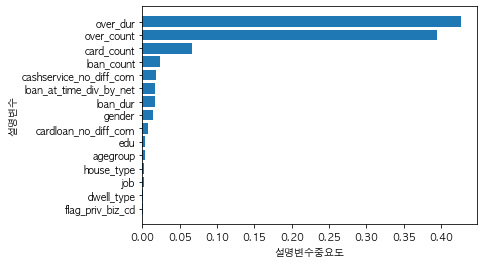

In [12]:
df_importance.sort_values("Importance",ascending=True,inplace=True)
coordinates=range(len(df_importance))
plt.barh(y=coordinates,width=df_importance["Importance"])
plt.yticks(coordinates,df_importance["Feature"])
plt.xlabel("설명변수중요도")
plt.ylabel("설명변수")

# 4.RF모델이 계산한 probability를 사용한 차주 신용점수 도출

In [13]:
prob = rf_final.predict_proba(df_raw_x)
prob

array([[0.8890944 , 0.1109056 ],
       [0.94934646, 0.05065354],
       [0.93998944, 0.06001056],
       ...,
       [0.98130778, 0.01869222],
       [0.97238672, 0.02761328],
       [0.87564388, 0.12435612]])

Text(0.5, 1.0, 'RF 분류 모델')

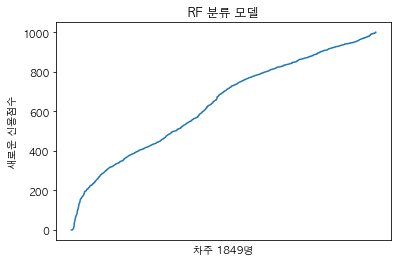

In [14]:
'''
# 연체할 확률(y=1일 확률) 분포를 선형적으로 변환하는 함수 적용하여 새로운 신용점수(new_score) 도출
# np.sqrt(i**i)함수: 1보다 작은 값을 넣는 경우, i가 증가할수록 output 값이 감소하는 감소 함수
# 즉, 연체할 확률이 높을수록 낮은 신용점수를 가지도록 변환하는 함수
# 새로운 신용점수(new_score)가 낮을수록 위험 고객
'''
prob_1_score = [i for i in prob[:,1]]
new_score = [np.sqrt(i**i) for i in prob_1_score] 

# 새로운 신용점수(new_score)를 기존 신용평가모델의 점수 범위인 1~1000점 범위로 변환
new_score = [i-min(new_score) for i in new_score]
new_score = [i*(1/max(new_score))*1000 for i in new_score]

# 1849명 차주들의 위험점수를 작은->큰 순서로 정렬하여 새로운 신용점수의 분포가 선형적인지 확인하는 그래프
sns.lineplot(x=range(len(new_score)), y=sorted(new_score))
plt.xlabel('차주 1849명')
plt.xticks([])
plt.ylabel('새로운 신용점수')
plt.title('RF 분류 모델')

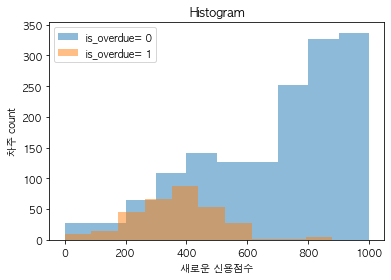

In [15]:
# 연체 여부(is_overdue)애 따른 차주들의 분포 확인
# 새로운 신용점수(new_score)가 낮을수록 연체한 차주, 높을수록 연체하지 않은 차주가 위치하는 것을 확인
df_test = pd.DataFrame({'new_score':new_score})
df_test['is_overdue'] = df_raw_y

plt.hist(df_test[df_test['is_overdue']==0]['new_score'], alpha=0.5, label='is_overdue= 0')
plt.hist(df_test[df_test['is_overdue']==1]['new_score'], alpha=0.5, label='is_overdue= 1')
plt.title('Histogram')
plt.ylabel('차주 count')
plt.xlabel('새로운 신용점수')
plt.legend()
plt.show()

# 5. 새로운 신용평가모형 개발: RF모델로 새롭게 계산한 차주 신용점수를 기반으로 12개의 등급 부여

In [16]:
# 1. 기존 신용 등급 구간으로 나눠주는 함수
def cal_credit_class(new_score):    
    df = pd.DataFrame({'new_score':new_score})
    df['class'] = new_score
    df['is_overdue'] = df_raw_y
    crit=200 
    bin_ = round((max(new_score)-crit)/4, 0)
    print('bin size ', bin_)
    print(crit, bin_+crit)
    df.loc[df['new_score'] < crit, 'class'] = 'un_C03'
    df.loc[((df['new_score'] >= crit)&(df['new_score'] < bin_+crit)), 'class'] = 'C04'
    df.loc[((df['new_score'] >= bin_+crit)&(df['new_score'] < bin_*2+crit)), 'class'] = 'C05'
    df.loc[((df['new_score'] >= bin_*2+crit)&(df['new_score'] < bin_*3+crit)), 'class'] = 'C06'
    df.loc[(df['new_score'] >= bin_*3+crit), 'class'] = 'over_C07'
    return df

# 2. 새롭게 도출한 신용 점수를 12개의 구간으로 나누어주는 함수
def cal_credit_class_div(new_score, classnum, lowerlimit):    
    df = pd.DataFrame({'chaju_id':df_raw['chaju_id'],'new_score':new_score})
    df['class'] = new_score
    df['is_overdue'] = df_raw_y
    crit = lowerlimit 
    bin_ = round((max(new_score)-crit)/(classnum), 0)
    print('새로운 신용평가 모형의 등급 구간 크기 ', bin_)
    print('새로운 신용평가모형의 고객 세분화를 위한 등급 구간 정의')
    for i in range(1,classnum+1):
        if i == 1:
            print(13-i,'등급 이하', crit+bin_*(i))
            df.loc[df['new_score'] < crit+bin_*(i), 'class'] = str(13-i)+'등급'
        elif i == classnum:
            print(13-i,'등급 이상', crit+bin_*(i-1))
            df.loc[df['new_score'] >= crit+bin_*(i-1), 'class'] = str(13-i)+'등급'
        elif i > 1:
            print(crit+bin_*(i-1), 13-i, '등급', crit+bin_*(i))
            df.loc[(df['new_score'] >= crit+bin_*(i-1))&(df['new_score'] < crit+bin_*(i)), 'class'] = str(13-i)+'등급'
    return df

# # 1. 새로운 신용평가모형과 기존 신용평가모형을 비교할 경우 사용
# df_class = cal_credit_class(risk_score)

## 2. 새로운 신용평가모형: 새로운 변수들로 도출한 새로운 신용점수를 12등급으로 나눈다.
df_class = cal_credit_class_div(new_score, 12, 30)
df_class

새로운 신용평가 모형의 등급 구간 크기  81.0
새로운 신용평가모형의 고객 세분화를 위한 등급 구간 정의
12 등급 이하 111.0
111.0 11 등급 192.0
192.0 10 등급 273.0
273.0 9 등급 354.0
354.0 8 등급 435.0
435.0 7 등급 516.0
516.0 6 등급 597.0
597.0 5 등급 678.0
678.0 4 등급 759.0
759.0 3 등급 840.0
840.0 2 등급 921.0
1 등급 이상 921.0


,chaju_id,new_score,class,is_overdue
0,C-1001,399.305383,8등급,1.0
1,C-1002,714.800382,4등급,0.0
2,C-1003,653.363918,5등급,0.0
3,C-1004,521.333251,6등급,0.0
4,C-1005,656.442137,5등급,0.0
...,...,...,...,...
1844,C-2995,300.492423,9등급,0.0
1845,C-2996,737.580538,4등급,0.0
1846,C-2998,986.823494,1등급,0.0
1847,C-2999,897.978449,2등급,0.0


In [17]:
# 새로운 신용평가모형의 12등급별 연체자 수
table=pd.crosstab(df_class['class'],df_class['is_overdue'], margins=True)
table

is_overdue,0.0,1.0,All
class,,,
10등급,47,47,94
11등급,21,16,37
12등급,31,12,43
1등급,266,0,266
2등급,256,2,258
3등급,269,4,273
4등급,159,0,159
5등급,96,2,98
6등급,99,32,131


# 6. 새로운 신용평가모형: KS 통계량 65% 달성 (기존 대비 1.6% 증대)

In [18]:
# 등급 순으로 table 정렬

# 1. 기존 신용평가모형과 KS 통계량 비교시 사용하는 table
# table = table.reindex(index=['un_C03','C04','C05','C06','over_C07','All'])

# 2. 새로운 신용평가모형
# table = table.reindex(index=['1등급 이상', '2등급', '3등급', '4등급', '5등급', '6등급', '7등급', '8등급', '9등급', '10등급', '11등급', '12등급 이하'])
table = table.reindex(index=['12등급', '11등급', '10등급', '9등급', '8등급', '7등급', '6등급', '5등급', '4등급', '3등급', '2등급', '1등급'])
table

is_overdue,0.0,1.0,All
class,,,
12등급,31,12,43
11등급,21,16,37
10등급,47,47,94
9등급,79,63,142
8등급,107,79,186
7등급,107,55,162
6등급,99,32,131
5등급,96,2,98
4등급,159,0,159


In [19]:
# K-S 통계량 계산을 위한 사전 작업
table['0_ratio']=table[0.0]/1537 # 전체 차주 중 연체하지 않은 1537명 중에, 각 등급별 연체하지 않은 사람의 비율
table['1_ratio']=table[1.0]/312 # 전체 차주 중 연체한 312명 중에, 각 등급별 연체한 사람의 비율
table

is_overdue,0.0,1.0,All,0_ratio,1_ratio
class,,,,,
12등급,31,12,43,0.020169,0.038462
11등급,21,16,37,0.013663,0.051282
10등급,47,47,94,0.030579,0.150641
9등급,79,63,142,0.051399,0.201923
8등급,107,79,186,0.069616,0.253205
7등급,107,55,162,0.069616,0.176282
6등급,99,32,131,0.064411,0.102564
5등급,96,2,98,0.062459,0.006410
4등급,159,0,159,0.103448,0.000000


In [20]:
# K-S 통계량 계산을 위한 table 생성
ks_table=table[['0_ratio','1_ratio']]
ks_table['index'] = ks_table.index
ks_table

<ipython-input-20-1167487acd2b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ks_table['index'] = ks_table.index


is_overdue,0_ratio,1_ratio,index
class,,,
12등급,0.020169,0.038462,12등급
11등급,0.013663,0.051282,11등급
10등급,0.030579,0.150641,10등급
9등급,0.051399,0.201923,9등급
8등급,0.069616,0.253205,8등급
7등급,0.069616,0.176282,7등급
6등급,0.064411,0.102564,6등급
5등급,0.062459,0.006410,5등급
4등급,0.103448,0.000000,4등급


In [21]:
# K-S 통계량 계산을 위한 누적확률 계산
ks_table['0_cum']=  ks_table['0_ratio'].cumsum()
ks_table['1_cum']=  ks_table['1_ratio'].cumsum()
ks_table

<ipython-input-21-a5c983bc7f6c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ks_table['0_cum']=  ks_table['0_ratio'].cumsum()


is_overdue,0_ratio,1_ratio,index,0_cum,1_cum
class,,,,,
12등급,0.020169,0.038462,12등급,0.020169,0.038462
11등급,0.013663,0.051282,11등급,0.033832,0.089744
10등급,0.030579,0.150641,10등급,0.064411,0.240385
9등급,0.051399,0.201923,9등급,0.115810,0.442308
8등급,0.069616,0.253205,8등급,0.185426,0.695513
7등급,0.069616,0.176282,7등급,0.255042,0.871795
6등급,0.064411,0.102564,6등급,0.319453,0.974359
5등급,0.062459,0.006410,5등급,0.381913,0.980769
4등급,0.103448,0.000000,4등급,0.485361,0.980769


(array([-20.,   0.,  20.,  40.,  60.,  80., 100., 120.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

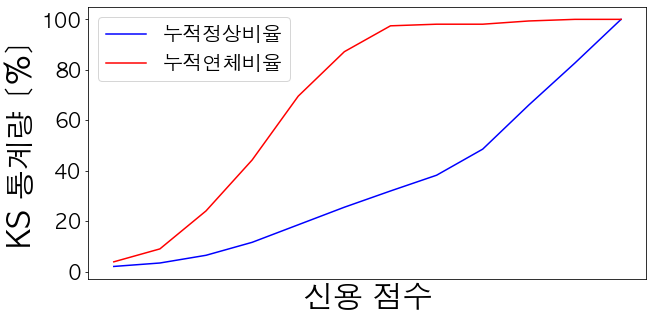

In [22]:
# ks_fin=ks_fin.drop(index=['All']) # 1.기존 신용평가모형과 비교할 경우 all삭제 필요
fs=30
plt.figure(figsize=(10,5))
plt.plot(ks_table['index'], ks_table['0_cum']*100,label='누적정상비율', c='b')
plt.plot(ks_table['index'],ks_table['1_cum']*100,label='누적연체비율', c='r')
plt.legend(fontsize=fs-10)
plt.ylabel('KS 통계량 [%]',fontsize=fs)
plt.xlabel('신용 점수',fontsize=fs)
plt.xticks([])
plt.yticks(fontsize=fs-10)

## K-S 통계량: 65%
### K-S 통계량 정의 = $max(|누적불량구성비 - 누적우량구성비|)$

In [23]:
ks_value = round(abs(ks_table['1_cum']-ks_table['0_cum']).max(), 2)*100
ks_value

65.0

# 7. 새로운 신용평가모형과 기존 모형의 비교

## 📌목표: 기존 등급제에서는 등급 간의 변별력 약화로 인해 대출 심사 불이익을 받던, 이탈율 높은 “저위험-고수익 차주” 발굴

#### "저위험-고수익 차주"란?: 대출 이후 연체하지 않은 저위험-고수익 고객

### 기존 모형의 등급 구간

In [24]:
# df_raw = pd.read_csv('wo_thin.csv', engine='python', encoding='cp949')
df = pd.read_csv('df_final.csv', engine='python')

df_y=df["is_overdue"]
df_x=df.drop("is_overdue",axis=1,inplace=False)

table=pd.crosstab(df['credit_class'],df['is_overdue'], margins=True)
table

is_overdue,0.0,1.0,All
credit_class,,,
C02,2,2,4
C03,106,12,118
C04,513,54,567
C05,625,88,713
C06,270,78,348
C07,21,56,77
C08,0,18,18
C09,0,4,4
All,1537,312,1849


### 기존 모형에서 저신용 차주 (7등급 이하)의 연체 여부 확인

In [25]:
low_class = df[(df['credit_class']=='C07')|(df['credit_class']=='C08')|(df['credit_class']=='C09')]
low_class_7 = df[(df['credit_class']=='C07')]
low_class_8 = df[(df['credit_class']=='C08')]
low_class_9 = df[(df['credit_class']=='C09')]

In [26]:
low_class_table=pd.crosstab(low_class['credit_class'],low_class['is_overdue'], margins=True)
low_class_table

is_overdue,0.0,1.0,All
credit_class,,,
C07,21,56,77
C08,0,18,18
C09,0,4,4
All,21,78,99


In [27]:
low_class_7_table=pd.crosstab(low_class_7['credit_class'],low_class_7['is_overdue'], margins=True)
low_class_8_table=pd.crosstab(low_class_8['credit_class'],low_class_8['is_overdue'], margins=True)
low_class_9_table=pd.crosstab(low_class_9['credit_class'],low_class_9['is_overdue'], margins=True)

## 📌 타겟 고객 설정: 기존 신용 등급 7등급 차주 중 대출 이후 연체하지 않은 차주
##  (7등급 고객의 27%)

In [28]:
new_customer = low_class_7[low_class_7['is_overdue']==0.0]
new_customer.head(n=1)

,chaju_id,credit_class,score_risk,gender,age,agegroup,job,edu,dwell_type,house_type,marriage,income_home_grp,income_ind_grp,expenditure_grp,child_cd,no_child,flag_priv_biz_cd,net_income,family_size,income_person,card_count,loan_amt,loan_dur,loan_count,over_amt,over_dur,over_count,is_overdue,sum_loan_at_time,sum_cashservice_3y,sum_cardloan_3y,no_cashservice_3y,no_cardloan_3y,no_creditcard_over,sum_creditcard_over,max_loan_amt,max_over_amt,income_ind_test,expend_ind_test,ind_net_income,loan_at_time_div_by_net,cardloan_no_diff_com,cashservice_no_diff_com
53,C-1056,C07,608,남성,42,40대,기능/노무직,고등학교 졸업,월세,오피스텔,미혼,300-399만원,300-399만원,100-199만원,Y,0,N,200,1,200.0,4.0,2800.0,7.0,1.0,0.0,0.0,0.0,0.0,2800.0,0.0,0.0,0.0,0.0,0.0,0.0,2800.0,0.0,350,150,200,1.17407,0.0,0.0


### 기존 모형에서 신용 등급 7등급 차주 중 연체하지 않은 차주의 특징 파악 (EDA)

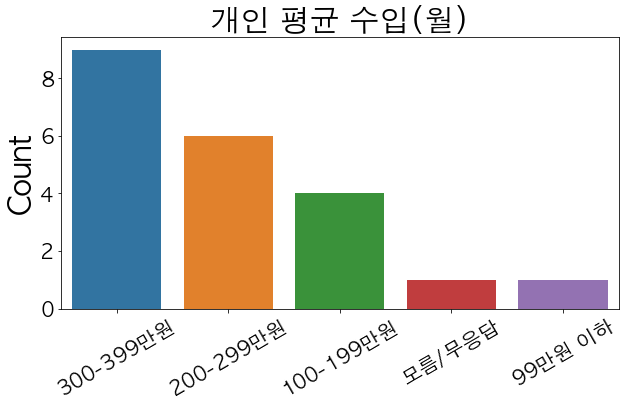

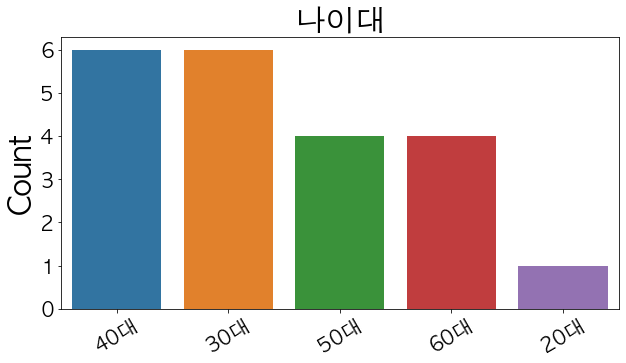

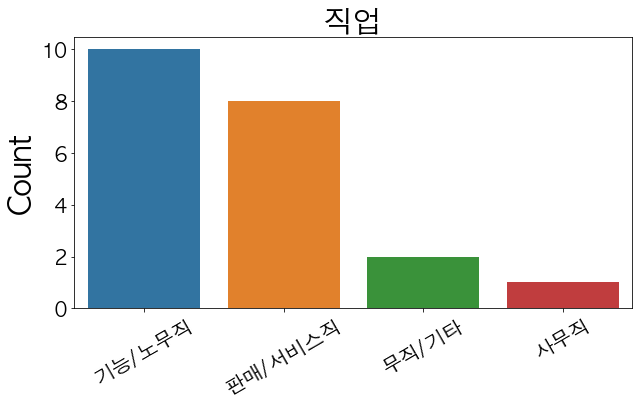

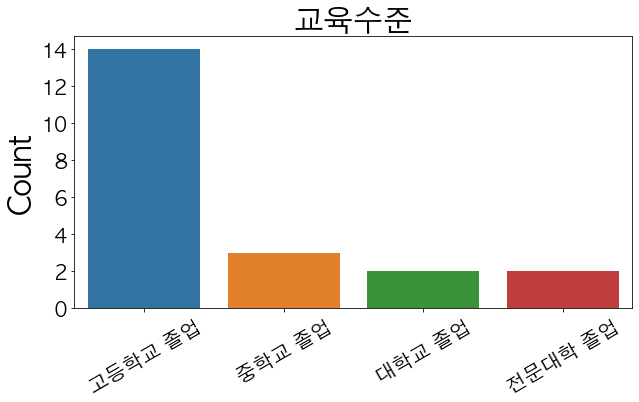

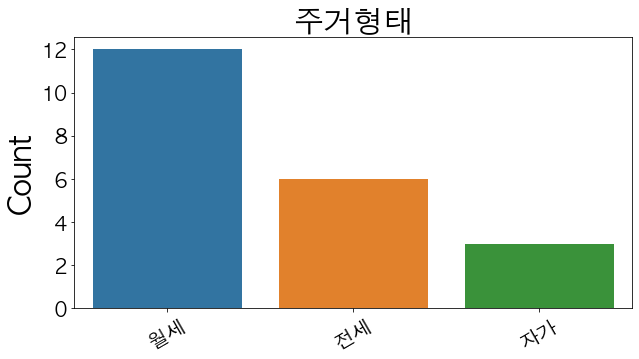

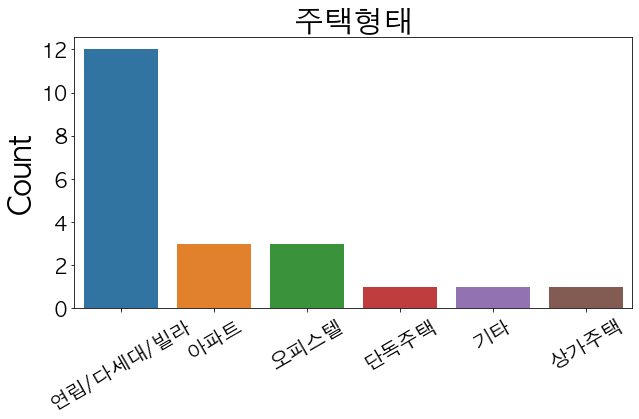

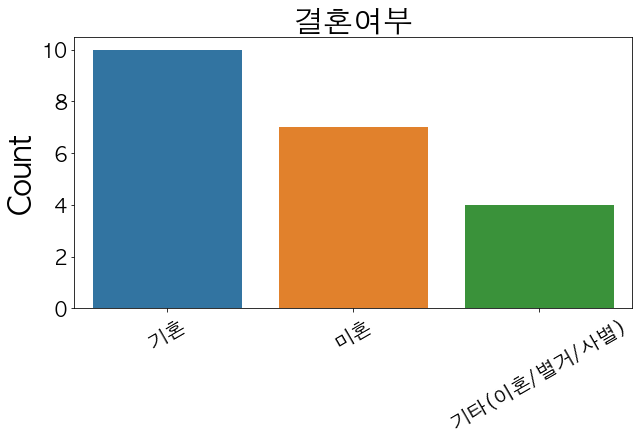

In [29]:
name = ['개인 평균 수입(월)','나이대', '직업', '교육수준', '주거형태', '주택형태','결혼여부']
for i, n in zip(['income_ind_grp','agegroup','job','edu','dwell_type','house_type','marriage'], name):
    fs=30
    plt.figure(figsize=(10,5))
    sns.countplot(x=new_customer[i], order=new_customer[i].value_counts().index)
    plt.title(n, fontsize=fs)
    plt.ylabel('Count',fontsize=fs)
    plt.xlabel('',fontsize=0)
    plt.xticks(fontsize =fs-10, rotation=30)
    plt.yticks(fontsize =fs-10)
    plt.show()
    plt.close()

### 기존 모형에서 신용 등급 7등급 차주 중 연체하지 않은 차주에 대한 기존+새 신용 점수, 등급 dataframe 생성

In [30]:
new_cust_id = list(new_customer['chaju_id'].values)

df_new_cust = pd.DataFrame({'chaju_id':new_cust_id})
df_new_cust['before_safe_score'] = df_new_cust['chaju_id']
df_new_cust['after_safe_score'] = df_new_cust['chaju_id']
df_new_cust['before_class'] = df_new_cust['chaju_id']
df_new_cust['after_class'] = df_new_cust['chaju_id']
 
for i in range(len(df_new_cust)):
    before_safe_score = 1000-df_raw[df_raw['chaju_id']==df_new_cust['chaju_id'][i]]['score_risk'].values[0]
    df_new_cust['before_safe_score'][i]=before_safe_score
    df_new_cust['after_safe_score'][i]=df_class[df_class['chaju_id']==df_new_cust['chaju_id'][i]]['new_score'].values[0]
    df_new_cust['before_class'][i]=df_raw[df_raw['chaju_id']==df_new_cust['chaju_id'][i]]['credit_class'].values[0]
    df_new_cust['after_class'][i]=df_class[df_class['chaju_id']==df_new_cust['chaju_id'][i]]['class'].values[0]

df_new_cust

,chaju_id,before_safe_score,after_safe_score,before_class,after_class
0,C-1056,392,790.767,C07,3등급
1,C-1225,322,443.616,C07,7등급
2,C-1240,369,467.947,C07,7등급
3,C-1266,392,557.434,C07,6등급
4,C-1276,302,7.19946,C07,12등급
5,C-1299,352,406.12,C07,8등급
6,C-1322,359,435.245,C07,7등급
7,C-1335,302,397.257,C07,8등급
8,C-1342,379,244.526,C07,10등급
9,C-1377,389,404.491,C07,8등급


### "등급 변화(dif_class) = 새로운 등급 - 기존 등급" 확인
### 의미:
#### 등급 변화>0 => 더 위험한 차주로 분류

#### 등급 변화<0 => 더 안전한 차주로 분류

In [31]:
df_new_cust['dif_class'] = df_new_cust['after_class']

df_new_cust['dif_class'] = df_new_cust['after_class'].apply(lambda x: x[0] if x=='1등급' else x[:-2])
df_new_cust['dif_class'] = df_new_cust['dif_class'].apply(lambda x: int(x) - 7)
df_new_cust

,chaju_id,before_safe_score,after_safe_score,before_class,after_class,dif_class
0,C-1056,392,790.767,C07,3등급,-4
1,C-1225,322,443.616,C07,7등급,0
2,C-1240,369,467.947,C07,7등급,0
3,C-1266,392,557.434,C07,6등급,-1
4,C-1276,302,7.19946,C07,12등급,5
5,C-1299,352,406.12,C07,8등급,1
6,C-1322,359,435.245,C07,7등급,0
7,C-1335,302,397.257,C07,8등급,1
8,C-1342,379,244.526,C07,10등급,3
9,C-1377,389,404.491,C07,8등급,1


### 신용 점수 변화(dif_score) 확인

In [32]:
df_new_cust['dif_score'] = df_new_cust['after_safe_score']
df_new_cust['dif_score'] = df_new_cust['after_safe_score']-df_new_cust['before_safe_score']
df_new_cust

,chaju_id,before_safe_score,after_safe_score,before_class,after_class,dif_class,dif_score
0,C-1056,392,790.767,C07,3등급,-4,398.767
1,C-1225,322,443.616,C07,7등급,0,121.616
2,C-1240,369,467.947,C07,7등급,0,98.9468
3,C-1266,392,557.434,C07,6등급,-1,165.434
4,C-1276,302,7.19946,C07,12등급,5,-294.801
5,C-1299,352,406.12,C07,8등급,1,54.1198
6,C-1322,359,435.245,C07,7등급,0,76.245
7,C-1335,302,397.257,C07,8등급,1,95.2569
8,C-1342,379,244.526,C07,10등급,3,-134.474
9,C-1377,389,404.491,C07,8등급,1,15.4908


# 📌기존 모형에서 7등급 차주로 분류되었지만 연체하지 않은 차주 중에서 
# 새로운 모형에서 등급이 상승하여 기존 신용평가모형으로 인한 불이익이 해소된 차주

등급 상승 & 점수 상승한 차주

In [33]:
df_new_cust[df_new_cust['dif_class']<0]

,chaju_id,before_safe_score,after_safe_score,before_class,after_class,dif_class,dif_score
0,C-1056,392,790.767,C07,3등급,-4,398.767
3,C-1266,392,557.434,C07,6등급,-1,165.434
13,C-1887,342,535.725,C07,6등급,-1,193.725
15,C-2214,396,776.359,C07,3등급,-4,380.359
17,C-2832,395,754.637,C07,4등급,-3,359.637
18,C-2849,396,528.545,C07,6등급,-1,132.545
19,C-2946,392,585.579,C07,6등급,-1,193.579
20,C-2980,386,531.099,C07,6등급,-1,145.099


등급 변화는 없지만 점수 상승한 차주

In [34]:
df_new_cust[df_new_cust['dif_class']==0]

,chaju_id,before_safe_score,after_safe_score,before_class,after_class,dif_class,dif_score
1,C-1225,322,443.616,C07,7등급,0,121.616
2,C-1240,369,467.947,C07,7등급,0,98.9468
6,C-1322,359,435.245,C07,7등급,0,76.245
11,C-1573,382,479.478,C07,7등급,0,97.4779
12,C-1681,392,438.223,C07,7등급,0,46.2226


등급 하락한 차주

In [35]:
df_new_cust[df_new_cust['dif_class']>0]

,chaju_id,before_safe_score,after_safe_score,before_class,after_class,dif_class,dif_score
4,C-1276,302,7.19946,C07,12등급,5,-294.801
5,C-1299,352,406.12,C07,8등급,1,54.1198
7,C-1335,302,397.257,C07,8등급,1,95.2569
8,C-1342,379,244.526,C07,10등급,3,-134.474
9,C-1377,389,404.491,C07,8등급,1,15.4908
10,C-1405,372,377.858,C07,8등급,1,5.85835
14,C-2099,382,0.00222388,C07,12등급,5,-381.998
16,C-2383,336,237.907,C07,10등급,3,-98.0929


기존 등급제모형 7등급 전체 차주 중 점수 상승한 차주: 22.1%

In [36]:
len(df_new_cust[df_new_cust['dif_score']>0])/77

0.22077922077922077

## 📌 기존 등급제모형 7등급 차주 중 불이익 받았던 차주 중 점수 상승한 차주: 81.0%

In [37]:
len(df_new_cust[df_new_cust['dif_score']>0])/21

0.8095238095238095

## 📌 기존 등급제모형 7등급 차주 중 불이익 받았던 차주의 평균 상승 점수: 152점
이들의 신용점수는 최소 5.8점에서 최대 399점 상승

In [38]:
np.mean(list(df_new_cust[df_new_cust['dif_score']>0]['dif_score'].values))

151.78703032842938

In [39]:
min(list(df_new_cust[df_new_cust['dif_score']>0]['dif_score'].values))

5.858348779895664

In [40]:
max(list(df_new_cust[df_new_cust['dif_score']>0]['dif_score'].values))

398.76724756096075

## 기존 등급제모형 7등급 차주 중 불이익 받았던 차주의 새로운 신용점수 분포
이들의 새로운 신용점수는 최소 378점에서 최대 791점

377.85834877989566
790.7672475609608


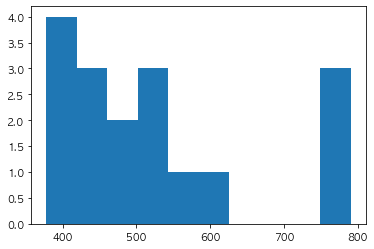

In [41]:
print(min(list(df_new_cust[df_new_cust['dif_score']>0]['after_safe_score'].values)))
print(max(list(df_new_cust[df_new_cust['dif_score']>0]['after_safe_score'].values)))
plt.hist(list(df_new_cust[df_new_cust['dif_score']>0]['after_safe_score'].values))
plt.show()

이들의 기존 등급제모형에서의 점수 분포는 최소 302점에서 최대 396점

302
396


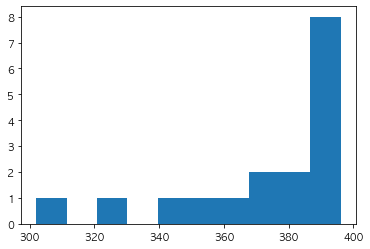

In [42]:
print(min(list(df_new_cust[df_new_cust['dif_score']>0]['before_safe_score'].values)))
print(max(list(df_new_cust[df_new_cust['dif_score']>0]['before_safe_score'].values)))
plt.hist(list(df_new_cust[df_new_cust['dif_score']>0]['before_safe_score'].values))
plt.show()

## 기존 등급제모형 7등급 차주 중 불이익 받았던 차주의 평균 상승 등급: 0.7등급

In [43]:
np.mean(list(df_new_cust[df_new_cust['dif_score']>0]['dif_class'].values))

-0.7058823529411765

# 📌 8. 새로운 신용평가 모형에서 차주의 대출 승인/거절 사유 도출 
## Shap value 분석 사용

[장점]

1. ensemble model 변화에 상관없는 일관성 높은 변수 중요도 도출 기능

2. black box 모델에서 알 수 없는 변수가 목표변수에 미치는 영향의 방향성(양/음)을 제공

# 해석 방법
각 차주마다 설명변수가 영향을 끼치는 것 확인하는 그래프

빨간색이 목표변수가 0.75값을 가지는데 긍정적인 영향을 미친 변수

파란색이 목표변수가 0.03인 값을 가지는데 부정적인 영향을 미친 변수

### 연체 확률이 높게 예측된 차주의 원인 분석
연체 기간, 연체 횟수, 연체 금액이 높기 때문

In [50]:
import shap
explainer = shap.TreeExplainer(rf_final)

choosen_instance = df_train_x.iloc[1]
shap_values = explainer.shap_values(choosen_instance)
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], choosen_instance)

### 연체 확률이 낮게 예측된 차주의 원인 분석
연체 기간, 연체 횟수가 없기 때문

In [51]:
choosen_instance = df_train_x.iloc[6] 
shap_values = explainer.shap_values(choosen_instance)
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], choosen_instance)